In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [64]:
using Revise
using Plots
using MCMCChains
using StatsPlots

In [3]:
includet("TCVAR_model.jl")
includet("carter_kohn_algorythm.jl")
includet("model_visualisation.jl")
includet("utills.jl")
includet("gibbs_steps.jl")
includet("gibbs_sampler.jl")

In [84]:
   
    true_var_coeff = [.3 .1;  .4 .6]
    true_trend_covariance =  diagm([.02/10, .01/10] .^2) 

    p = -0.7 * .015 * 0.011

    true_cycle_covariance = [(.015)^2 p
                             p (.011)^2]

     
    true_initial_trend_mean = [.02, .01]
    true_initial_trend_covariance = Matrix(I, 2,2)
    true_initial_cycle_mean = [.0, .0]
    true_initial_cycle_covariance = [(.015)^2 0
                                      0 (.011)^2]
                                   
    
    true_model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        true_initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)


    initial_state = [.02, .008]
    true_states, observations= sample(true_model,  [.02, .01, .0, .0], 110)

    n_presample = 10

    presample_data, data = observations[1:n_presample,:], observations[n_presample+1:end,:]

    true_states = true_states[n_presample+1:end,:]
  
 
 

100×4 Matrix{Float64}:
  0.00797006  0.0217643  -0.0230271   -0.00708988
  0.00530445  0.0232844  -0.0432541    0.0019318
  0.00591273  0.024084   -0.0102812   -0.0203222
  0.00599707  0.0224443   0.00264198  -0.0153653
  0.00695599  0.0220328  -0.0227797   -0.00376976
  0.00572395  0.0211886  -0.0232939   -0.00413733
  0.00695318  0.0188126   0.00272169  -0.0213898
  0.00556872  0.0204101   0.00646304  -0.019372
  0.00855463  0.0213477  -0.00687423   0.000679514
  0.00786866  0.0214726   0.0192859   -0.0203812
  ⋮                                   
 -0.00552682  0.0164704  -0.00951175  -0.00494004
 -0.00718503  0.0145207  -0.0106492   -0.00614171
 -0.00780792  0.0146648   0.0221035   -0.0218197
 -0.00642677  0.0166383  -0.027503     0.00962726
 -0.00883018  0.0172171  -0.00832298   0.00323528
 -0.00704176  0.016917   -0.0121296   -0.000503453
 -0.00670076  0.0165419  -0.00605903  -0.0135535
 -0.00593652  0.0171836  -0.00154173  -0.0259764
 -0.00575582  0.0170457  -0.0203419    0.00304

In [85]:
display(mean(presample_data[:,1], dims=1)[1])
display(mean(presample_data[:,2] - presample_data[:,1], dims=1)[1])

0.011565680890482776

0.009882612413273751

In [86]:
mean(data, dims=1)

1×2 Matrix{Float64}:
 -0.00434281  0.019266

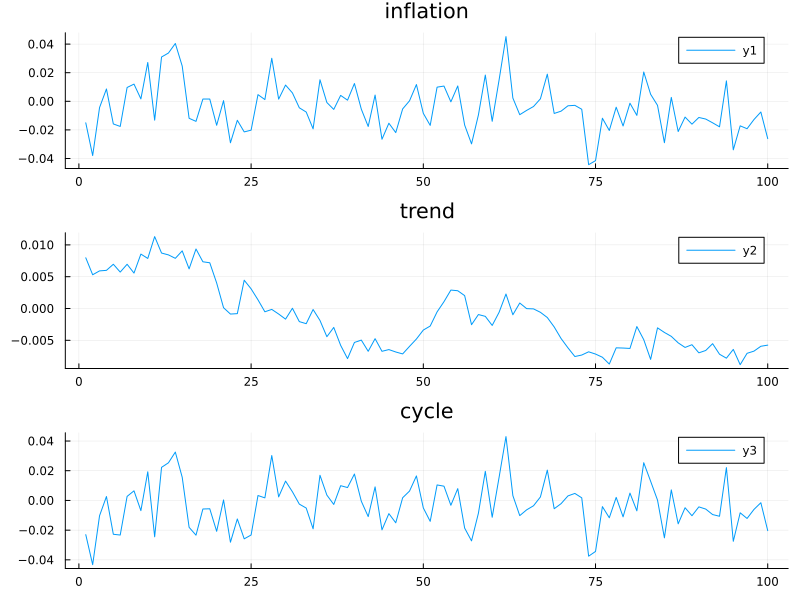

In [87]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

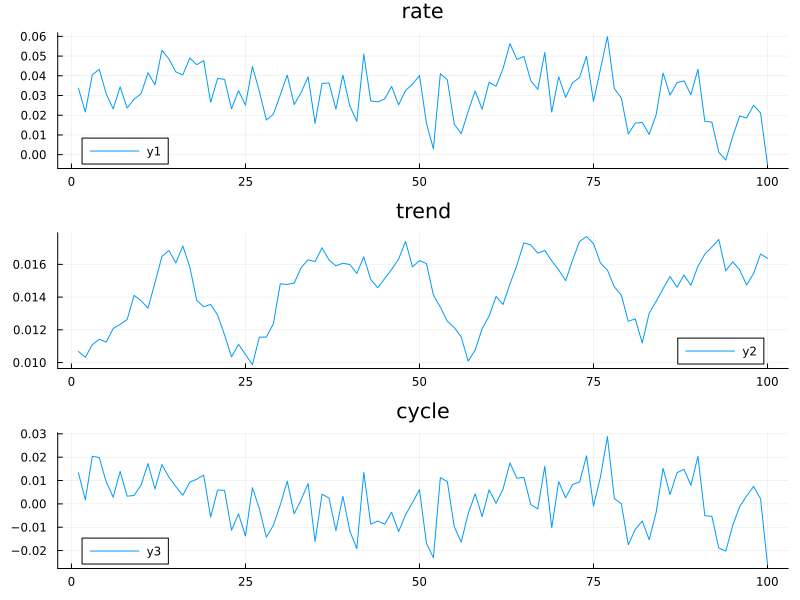

In [8]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [88]:
priors = (
        initial_trend_mean = [mean(presample_data[:,1], dims=1)[1], mean(presample_data[:,2] - presample_data[:,1], dims=1)[1]],
        trend_covariance_df = 100,
        trend_covariance_mean = true_trend_covariance * (100 + 2 +1) #diagm([2, 1].^2/100) * (100 + 2 +1),
        )

(initial_trend_mean = [0.011565680890482776, 0.009882612413273751], trend_covariance_df = 100, trend_covariance_mean = [0.000412 0.0; 0.0 0.000103])

In [89]:
state_smoothed_samples, trend_covariance_samples = gibs_sampler(data, priors, 1_000)

state_smoothed_mean, state_smoothed_lower, state_smoothed_upper = compute_posterior_statistics(state_smoothed_samples, credible_level=0.95)  

([-0.0030602010549289987 0.022974973457625572 -0.011967235053771395 0.0026839559750160284; -0.0033515118141183176 0.02294717824597768 -0.03452172272308638 0.010865154902186465; … ; -0.015940614106247652 0.023184873058151995 0.008477436218428903 -0.02194474059954987; -0.01514733107339508 0.02331820835485064 -0.010898224926003208 0.0061348139004863585], [-0.01389224625578216 0.012727548812988768 -0.022961842636351492 -0.010502129420114813; -0.01348208248486595 0.013055275888738773 -0.04528209783478289 -0.0018288327523850558; … ; -0.026181655827611568 0.013374921160966058 -0.0019875461358892484 -0.03334012800245094; -0.02564360532768856 0.013413279945189626 -0.02160347417513837 -0.005220024455021198], [0.007909455644023735 0.034099150620986424 -0.0010497831752622638 0.014911988298516619; 0.00732138949545877 0.03402301372090256 -0.02425886911770467 0.022538606824089227; … ; -0.005242507173600575 0.032464439749688996 0.0187008388092363 -0.010416258884791411; -0.004408631117977985 0.03329721

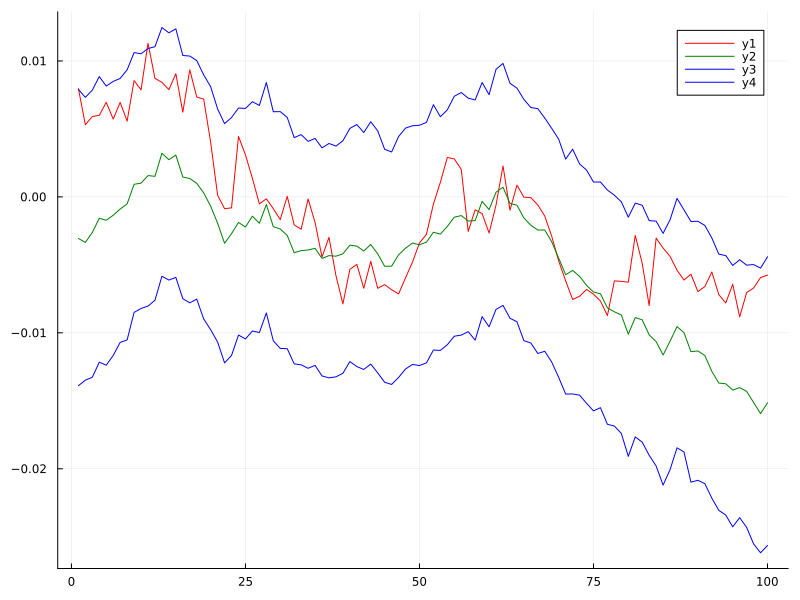

In [90]:
st = 1
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

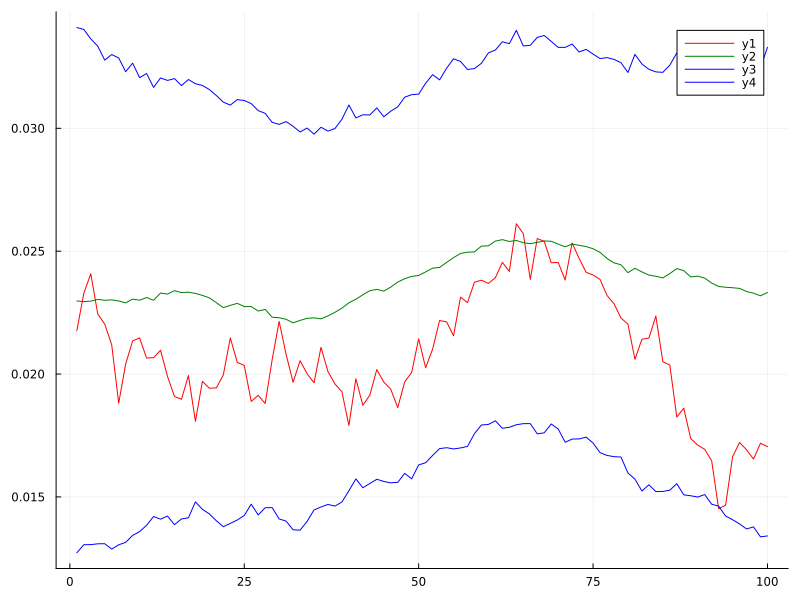

In [91]:
st = 2
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

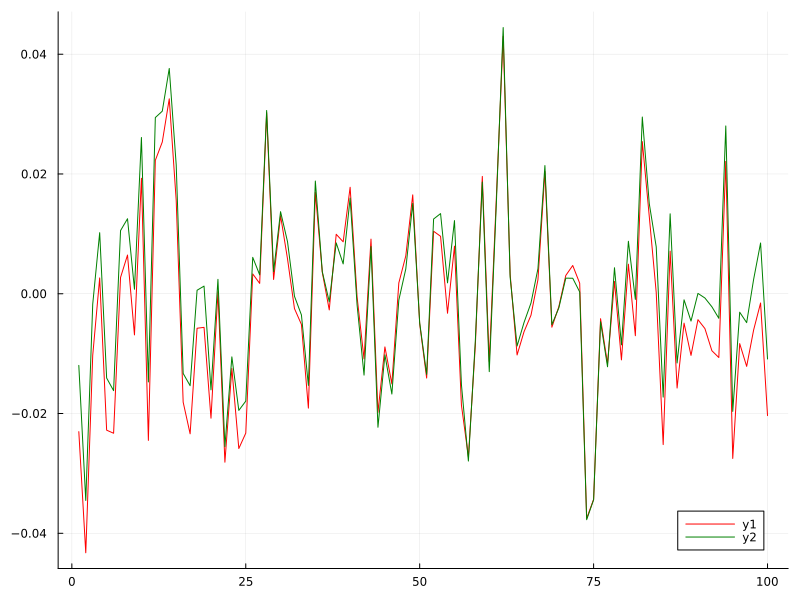

In [92]:
st = 3
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_smoothed_mean[:,st], color="green" )
#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

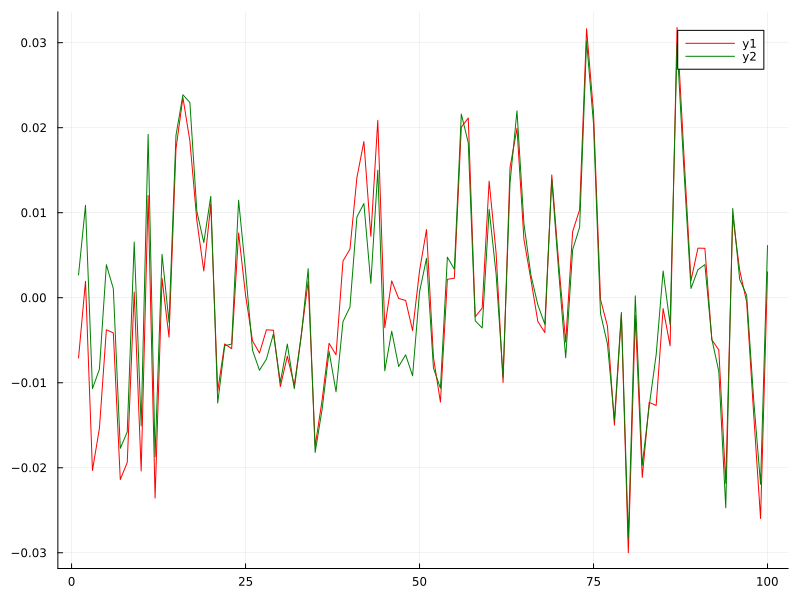

In [93]:
st = 4
plot(true_states[:,st]; color="red", size= (800, 600))

plot!(state_smoothed_mean[:,st], color="green" )
#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

In [94]:
Y = true_states[:,[1,2]]
e  = diff(Y, dims=1)
true_var = e' * e * 1/(size(Y,1)-1)
display(diag(true_var))
display(diag(true_var).^.5)

2-element Vector{Float64}:
 3.4488979629362947e-6
 1.0252987324906585e-6

2-element Vector{Float64}:
 0.0018571208800011632
 0.0010125703592791262

In [111]:
summarystats(trend_covariance_samples)

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

       Στ[1]    0.0000    0.0000    0.0000   403.8691   573.4141    1.0042     ⋯
       Στ[2]   -0.0000    0.0000    0.0000   316.5633   509.7168    1.0083     ⋯
       Στ[3]   -0.0000    0.0000    0.0000   316.5633   509.7168    1.0083     ⋯
       Στ[4]    0.0000    0.0000    0.0000   327.9050   501.3166    1.0007     ⋯
                                                                1 column omitted


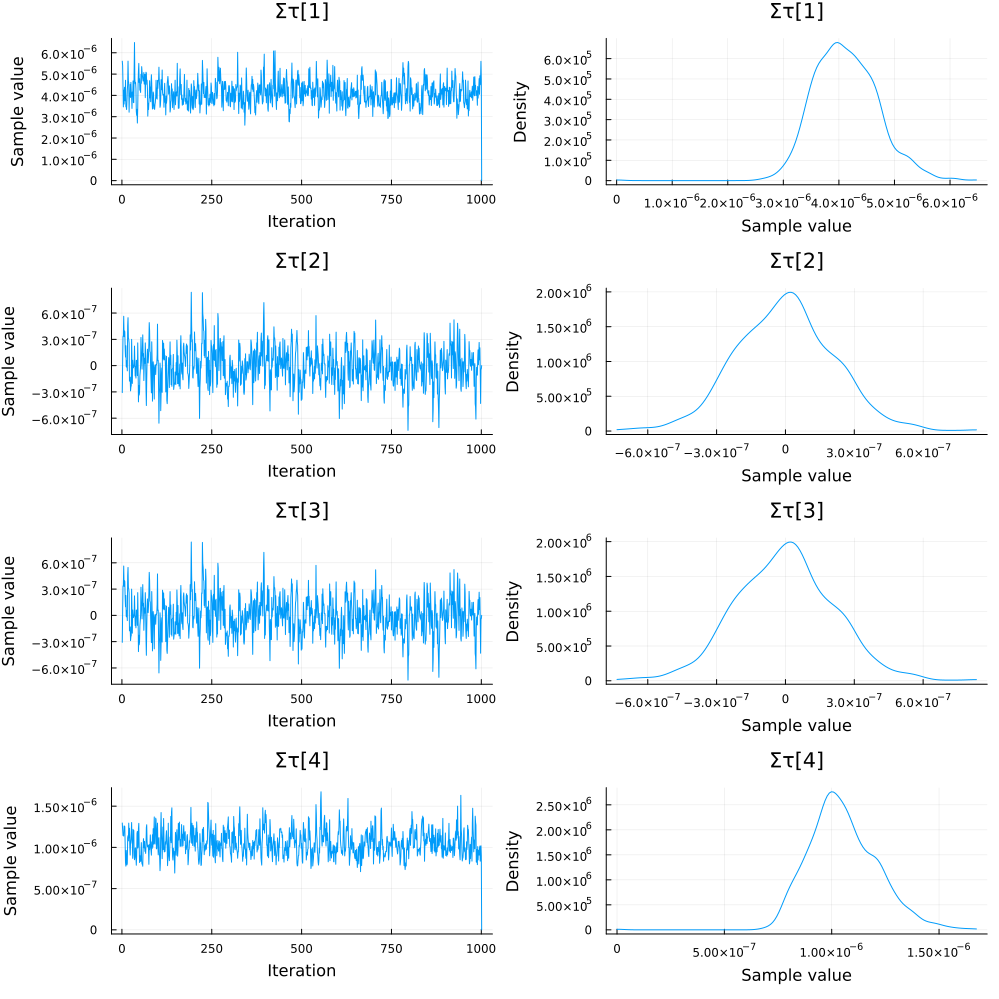

In [112]:
plot(trend_covariance_samples)

In [114]:
var_priors = minnesota_priors(data, λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])
reshape(var_priors, 3, 2)

3×2 Matrix{Normal}:
 Normal{Float64}(μ=0.0, σ=0.2)         Normal{Float64}(μ=0.0, σ=0.163894)
 Normal{Float64}(μ=0.0, σ=0.24406)     Normal{Float64}(μ=0.0, σ=0.2)
 Normal{Float64}(μ=0.0, σ=0.00338102)  Normal{Float64}(μ=0.0, σ=0.00277064)

In [44]:
d_post = size(data, 1) - 1 + priors.trend_covariance_df

post_dist = covariance_posterior(true_states[:,[1,2]], priors.trend_covariance_mean, d_post)

InverseWishart{Float64, PDMats.PDMat{Float64, Matrix{Float64}}}(
df: 199.0
Ψ: [0.0008366570717900143 2.4863016671118795e-6; 2.4863016671118795e-6 0.00019024550811097183]
)


In [45]:
true_var + priors.trend_covariance_mean

2×2 Matrix{Float64}:
 0.000416289  2.51142e-8
 2.51142e-8   0.000103881

In [46]:
cov_posterior = zeros(10_000, 2)

for n in 1:10_000
  cov_posterior[n,:,:] = diag(rand(post_dist))
end


display(mean(cov_posterior, dims=1) .* 100)
display(mean(cov_posterior, dims=1).^.5 *10) 
display(mode(cov_posterior[1]).^.5 * 10) 
display(mode(cov_posterior[2]).^.5 * 10) 

1×2 Matrix{Float64}:
 0.00042766  9.6903e-5

1×2 Matrix{Float64}:
 0.0206799  0.00984393

0.02112355338958164

0.019230896356647636

In [227]:
diag(true_trend_covariance) .^.5 * 10

2-element Vector{Float64}:
 0.02
 0.01

In [228]:
true_trend_covariance .^.5 .*10

2×2 Matrix{Float64}:
 0.02  0.0
 0.0   0.01

In [229]:
diag(priors.trend_covariance_mean) .^.5 *10

2-element Vector{Float64}:
 0.20297783130184438
 0.10148891565092219

In [230]:
[2, 1] .^2 / 100 

2-element Vector{Float64}:
 0.04
 0.01

In [231]:
stds = zeros(50_000, 2)


for n in 1:50_000
    stds[n,:] = diag(rand(InverseWishart(priors.trend_covariance_df, priors.trend_covariance_mean)))
end

display(mean(stds, dims=1).^.5 .*10)
display(mode(stds[1]) ^.5 * 10) 
display(mode(stds[2]) ^.5 * 10) 


1×2 Matrix{Float64}:
 0.0205993  0.0103109

0.020667918824022836

0.022280988369509945

In [147]:
stds = std.(eachcol(true_states[:,[3, 4]]))

2-element Vector{Float64}:
 0.01595265882577259
 0.012407786697950219

In [156]:
stds[2]/stds[1] * 0.2

0.15555760119315795

In [154]:
φ, Ω =  minnesota_priors(true_states[:,[3, 4]], λ1=0.2, λ2=1.0, λ3=1.0, p=1, zero_ownlag=[true, true])

reshape(φ, 2, 2)
Ω

2×2 Matrix{Float64}:
 0.2       0.257139
 0.155558  0.2